# Cell annotation - Pancreas Mouse

Let start with few imports :)

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
from openTSNE import TSNE
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import seaborn as sn
from scipy.stats import rankdata

from IPython.display import HTML, display
import tabulate

from cellannotation.annotate_samples import *

### Loading dataset

Datasets are available [here](https://github.com/PrimozGodec/cell-annotation/releases/0.1.0) download them in data directory. If you are using unix based operating system it can be done with running:

In [4]:
!wget -q -nc -P data/ https://github.com/PrimozGodec/cell-annotation/releases/download/0.1.0/panglao_gene_markers.csv.gz
!wget -q -nc -P data/ https://github.com/PrimozGodec/cell-annotation/releases/download/0.1.0/GSM2230761_mouse1_umifm_counts.csv.gz
!wget -q -nc -P data/ https://github.com/PrimozGodec/cell-annotation/releases/download/0.1.0/GSM2230762_mouse2_umifm_counts.csv.gz

In [5]:
df1 = pd.read_csv("data/GSM2230761_mouse1_umifm_counts.csv.gz", compression="gzip")
df2 = pd.read_csv("data/GSM2230762_mouse2_umifm_counts.csv.gz", compression="gzip")
gene_expressions_df = pd.concat([df1, df2])

### About data

In [6]:
print("Number of cells in dataset: " + str(gene_expressions_df.shape[0]))
print("Number of genes in dataset: " + str(gene_expressions_df.shape[1]))

Number of cells in dataset: 1886
Number of genes in dataset: 14881


### Data normalization

Data are normalized with CPM and log(1 + x)

In [7]:
gene_expressions_normalized_df = AnnotateSamples.log_cpm(gene_expressions_df.loc[:, "0610007P14Rik":])

In [17]:
# gene names in mrker genes and in dataset are not consistant - so we lower them
gene_expressions_normalized_df.columns = map(str.lower, gene_expressions_normalized_df.columns)

### Most expressed genes per cell

In [18]:
%%time
z_df = AnnotateSamples.mann_whitney_test(gene_expressions_normalized_df)

CPU times: user 5.8 s, sys: 529 ms, total: 6.33 s
Wall time: 6.72 s


In [19]:
z_threshold = 1

#### Statistics: Expressed genes per cell

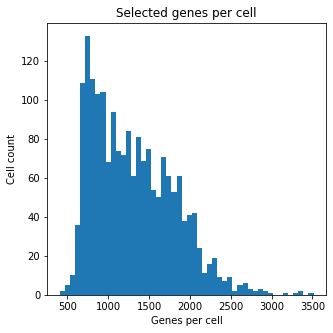

In [20]:
expressions_per_cell = (z_df > z_threshold).sum(axis=1)
plt.figure(figsize=(5,5))
plt.hist(expressions_per_cell, bins=50);
plt.title("Selected genes per cell");
plt.xlabel("Genes per cell")
plt.ylabel("Cell count");

### Loading marker genes

Here we load marker genes from Orange, select only genes for the target orangism: Human, and associate genes that are expressed in each cell type.

In [29]:
marker_genes_df = pd.read_csv("data/panglao_gene_markers.csv.gz", compression="gzip")
marker_genes_df = marker_genes_df.rename(columns={'Name': 'Gene'})
marker_genes_df = marker_genes_df[marker_genes_df["Organism"] == "Mouse"]
marker_genes_df["Gene"] = marker_genes_df["Gene"].str.lower()

Find out how many mathcing genes

In [30]:
len(set(gene_expressions_normalized_df.columns.values) & 
    set(marker_genes_df.loc[:, 'Gene'].values))

3135

### Assign labels

Labeling with filtering

In [31]:
%%time
scores_df, fdrs_df = AnnotateSamples.assign_annotations(
    z_df, marker_genes_df, gene_expressions_normalized_df, 60000)

scores_df = AnnotateSamples.filter_annotations(
    scores_df, fdrs_df, return_nonzero_annotations=True, p_threshold=0.05)

CPU times: user 3.38 s, sys: 243 ms, total: 3.62 s
Wall time: 3.54 s


In [32]:
labels = np.array(scores_df.columns.values)
labels_cells = scores_df.idxmax(axis=1)

#### Statistics: 10 most common labels

In [33]:
counts = Counter(labels_cells).most_common()
counts_show = [[k, "{:.03f}".format(v / len(labels))] for k, v in counts[:10]]

display(HTML("10 most common labels in the dataset and proportion of appearance"))
display(HTML(tabulate.tabulate(counts_show, tablefmt='html')))

Beta cells,1.578
Transient cells,1.547
Delta cells,1.075
Alpha cells,1.075
Hepatoblasts,0.733
Endothelial cells,0.578
Microfold cells,0.522
Pancreatic progenitor cells,0.36
Osteoclast precursor cells,0.323
Anterior pituitary gland cells,0.292


#### Confusion matrix

In [34]:
ids = [str(i) for i in list(gene_expressions_df.loc[:, "assigned_cluster"])]
ids_unique = sorted(list(set(ids)))
lables_no_nan = labels_cells.dropna()
labels_unique = sorted(list(set(lables_no_nan)))

confusion_matrix = np.zeros((len(labels_unique), len(ids_unique)))
for l, idx in zip(lables_no_nan, ids):
    confusion_matrix[labels_unique.index(l), ids_unique.index(idx)] += 1

In [35]:
# subsample confusion matrix
n_maxs = 3
sel_ind = []
for i in range(confusion_matrix.shape[1]):
    ind = confusion_matrix[:, i].argsort()[-n_maxs:]
    sel_ind += [i for i in ind if i not in sel_ind]
conf_sub_smp = confusion_matrix[sel_ind]
labels_unique_sub = np.array(labels_unique)[sel_ind]

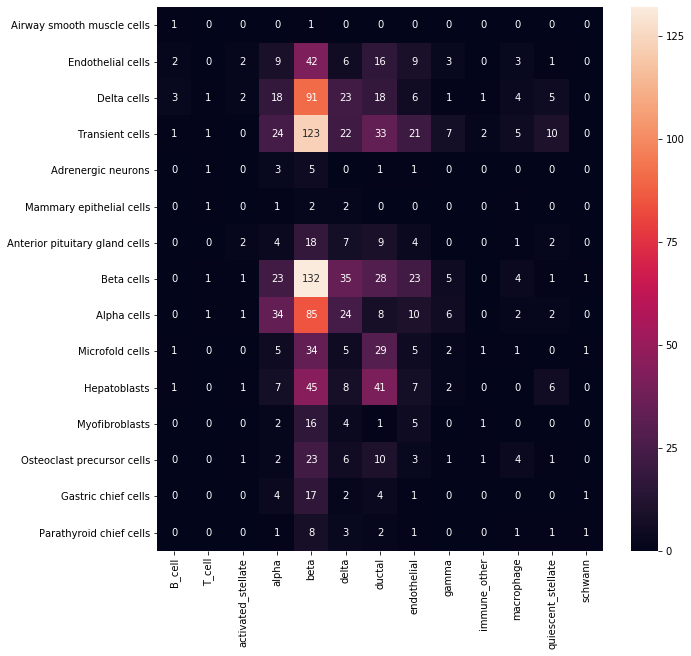

In [36]:
df_cm = pd.DataFrame(conf_sub_smp, index = labels_unique_sub, columns = ids_unique)
plt.figure(figsize=(10,10))
sn.heatmap(df_cm, annot=True, fmt='g');

### Dimensionality reduction with t-SNE

The dimensionality is first reduced with PCA and later t-SNE is applied on already reduced dimensions. 

In [37]:
pca = PCA(n_components=50)
pca_data = pca.fit_transform(gene_expressions_normalized_df)

In [38]:
tsne = TSNE(n_components=2, neighbors="approx", negative_gradient_method="fft", n_jobs=4)
data_embedded = tsne.fit(pca_data)

/Users/primoz/miniconda3/envs/orange/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/envs/orange/lib/python3.7/site-packages/pynndescent/rp_trees.py", line 133:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/Users/primoz/miniconda3/envs/orange/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../mi

### Clustering

In [39]:
clustering = DBSCAN(eps=4, min_samples=2).fit(data_embedded)
clusters = clustering.labels_

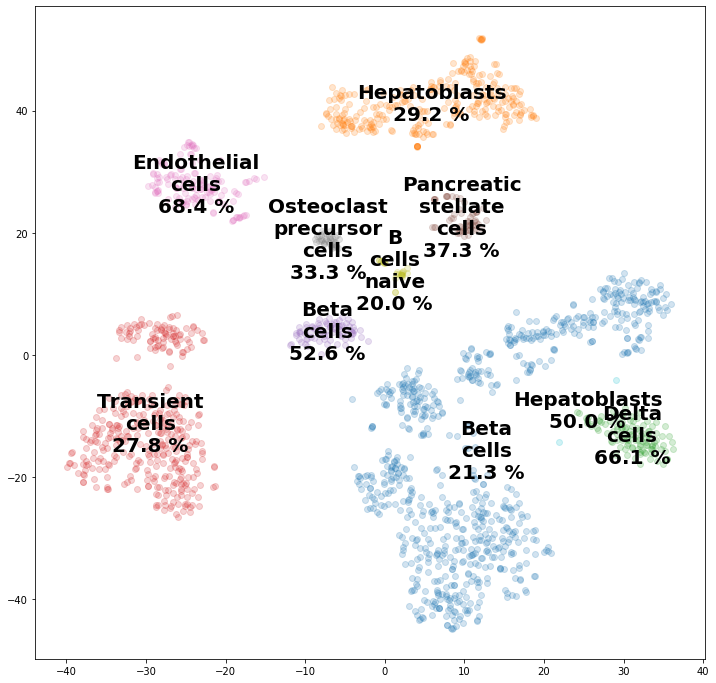

In [40]:
plt.figure(figsize=(12, 12))
for l in set(clusters):
    incl = clusters == l
    x = np.array(data_embedded)[incl, :]
    plt.scatter(x[:, 0], x[:, 1], label=l, alpha=0.2);
    
    center = x.mean(axis=0)    
    labels_cl = labels_cells.loc[incl].dropna()
    counts = Counter(labels_cl)
    
    max_el = "\n".join("{0}\n{1:.1f} %".format(
        "\n".join(k.split()), v / len(x) * 100) for k, v in counts.most_common(1))
    
    plt.annotate(max_el, 
                 center,
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold');

### Cells - genes heatmap

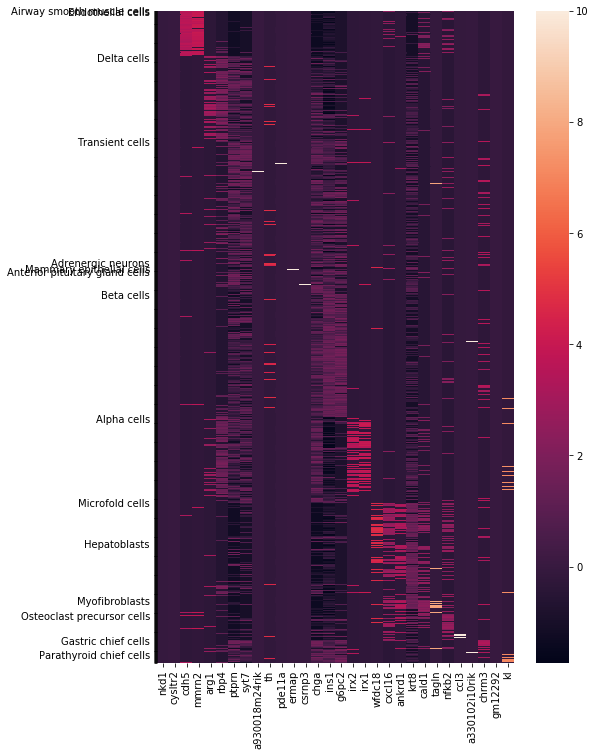

In [41]:
plt.figure(figsize=(8, 12))
n_genes_per_type = 2

# select genes with highest z-score for a cell in a group
selected_cells = np.array([]).astype(int)
selected_genes = np.array([]).astype(int)
y_tick_labels = []

labels_unique = sorted(list(set(labels_cells.dropna())))

for cell_type in labels_unique_sub:
    z_values_type = z_df[labels_cells == cell_type]
    genes_idx = z_values_type.mean(axis=0).argsort()[-n_genes_per_type:]
    selected_genes = np.concatenate([selected_genes, genes_idx])
    
    cells_idx1 = np.where(labels_cells == cell_type)[0]
    selected_cells = np.concatenate([selected_cells, cells_idx1])
    
    y_tick_labels += [cell_type] + [""] * (len(cells_idx1) - 1)


hm_array_df = z_df.iloc[selected_cells].iloc[:, selected_genes]
# hm_array_df = pd.DataFrame(hm_array, columns=genes_names[selected_genes])
hm_array_df = hm_array_df.clip(-100, 10)
sn.heatmap(hm_array_df, yticklabels=y_tick_labels);